In [ ]:
!pip install py7zr 
!pip install transformers
!pip install datasets
!pip install rouge-score
!pip install nltk
!pip install sentencepiece

In [2]:
from transformers import BertTokenizer, BertModel,BertConfig
configuration = BertConfig(num_hidden_layers=2,output_attentions=True)
model = BertModel(config=configuration)


In [3]:
import torch
import numpy as np
len_dataset=32
img_seq_len=10
tabular_seq_len=4
img_embeddings=torch.from_numpy(np.random.rand(len_dataset,img_seq_len,768)).float()
tabular_embeddings=torch.from_numpy(np.random.rand(len_dataset,tabular_seq_len,768)).float()
# radiomics_embeddings=torch.from_numpy(np.random.rand(1,3,768)).float()

In [4]:
a = torch.empty(len_dataset).uniform_(0, 1)
y=torch.bernoulli(a)

In [5]:
import numpy as np
batch_size=4

token_type_ids=torch.tensor(torch.cat([torch.zeros(batch_size,img_seq_len),torch.ones(batch_size,tabular_seq_len)],axis=-1),dtype=torch.int32)
position_ids=torch.tensor([list(range(img_seq_len))+list(range(tabular_seq_len)) for i in range(batch_size)],dtype=torch.int32)

<ipython-input-5-3fc0f8ea091e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids=torch.tensor(torch.cat([torch.zeros(batch_size,img_seq_len),torch.ones(batch_size,tabular_seq_len)],axis=-1),dtype=torch.int32)


In [6]:
import torch.nn as nn
class MyModel(nn.Module):
  def __init__(self,model,num_output_classes=2):
    super(MyModel,self).__init__()
    self.transformer_model=model
    self.linear1=nn.Linear(768,256)
    self.relu=nn.ReLU()
    self.linear2=nn.Linear(256,num_output_classes)
  def forward(self,random_embeddings,position_ids,token_type_ids):
    bert_output=self.transformer_model(inputs_embeds=random_embeddings,position_ids=position_ids,token_type_ids=token_type_ids)
    bert_output_avg=bert_output.last_hidden_state.mean(axis=1)
    x=self.linear1(bert_output_avg)
    x=self.relu(x)
    x=self.linear2(x)
    return x



In [7]:
mymodel=MyModel(model,num_output_classes=2)

In [8]:
from torch.utils.data import Dataset,DataLoader
# pass image embeddings and tabular data embeddings
class MyDataset(Dataset):
  def __init__(self,img_data,tabular_data,labels):
    self.img=img_data
    self.tab=tabular_data
    self.labels=labels
  def __len__(self):
    return len(self.img)
  def __getitem__(self,index):
    img_instance=self.img[index]
    tab_instance=self.tab[index]
    random_embedding=torch.cat([img_instance,tab_instance],axis=0)
    label_instance=self.labels[index]
    return random_embedding,label_instance

In [9]:
mydataset=MyDataset(img_embeddings,tabular_embeddings,y)

In [10]:
dataloader=DataLoader(mydataset,batch_size=batch_size)

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=0.001)

In [12]:
Epochs=1
mymodel.train()
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels=labels.long()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mymodel(inputs,position_ids,token_type_ids)
        loss = criterion(outputs, labels)
        print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
      

print('Finished Training')

tensor(0.6473, grad_fn=<NllLossBackward0>)
tensor(1.2784, grad_fn=<NllLossBackward0>)
tensor(1.1252, grad_fn=<NllLossBackward0>)
tensor(0.6855, grad_fn=<NllLossBackward0>)
tensor(0.7780, grad_fn=<NllLossBackward0>)
tensor(0.7270, grad_fn=<NllLossBackward0>)
tensor(1.3542, grad_fn=<NllLossBackward0>)
tensor(0.7256, grad_fn=<NllLossBackward0>)
Finished Training


In [15]:
with torch.no_grad():
  mymodel.eval()
  test_token_type_ids=torch.tensor(torch.cat([torch.zeros(1,img_seq_len),torch.ones(1,tabular_seq_len)],axis=-1),dtype=torch.int32)
  test_position_ids=torch.tensor([list(range(img_seq_len))+list(range(tabular_seq_len)) for i in range(1)],dtype=torch.int32)
  test_input=torch.from_numpy(np.random.rand(1,14,768)).float()
  test_outputs = mymodel(test_input,test_position_ids,test_token_type_ids)
  transformer_output=mymodel.transformer_model(inputs_embeds=test_input,position_ids=test_position_ids,token_type_ids=test_token_type_ids)

<ipython-input-15-c5ea27b5772d>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_token_type_ids=torch.tensor(torch.cat([torch.zeros(1,img_seq_len),torch.ones(1,tabular_seq_len)],axis=-1),dtype=torch.int32)


In [16]:
transformer_output.attentions[0].shape # (batch_size, num_attention_heads, sequence_length, sequence_length) , one for each block of encoder

torch.Size([1, 12, 14, 14])

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



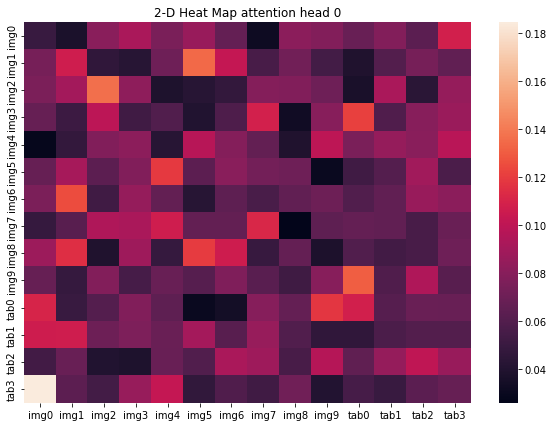

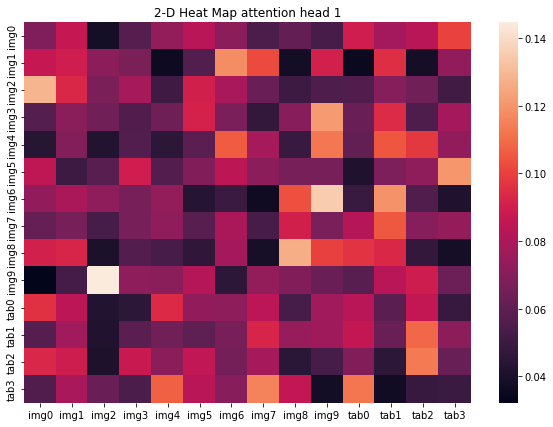

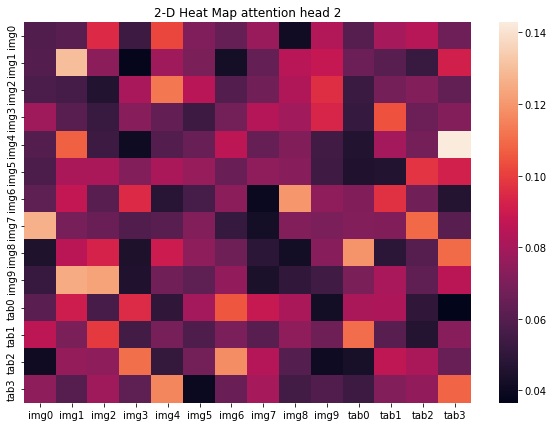

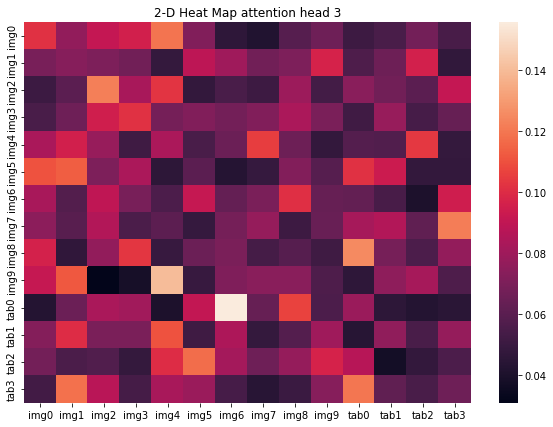

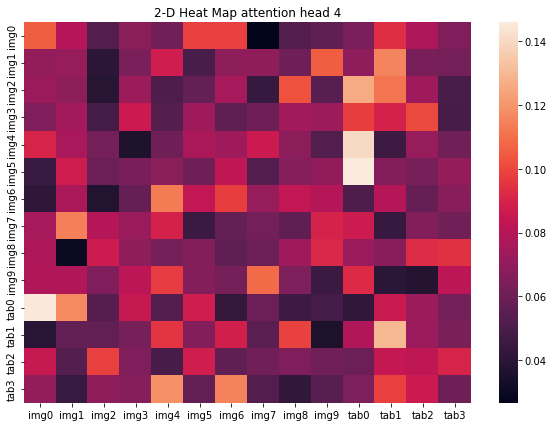

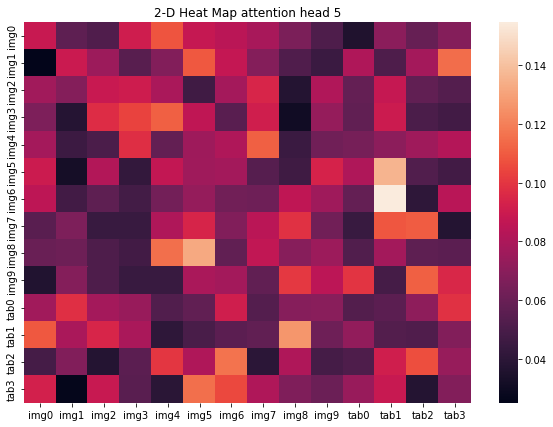

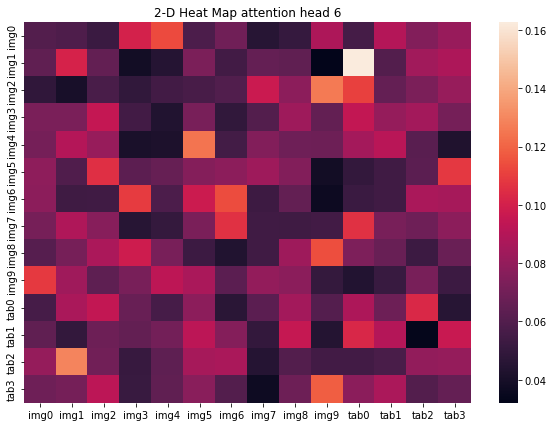

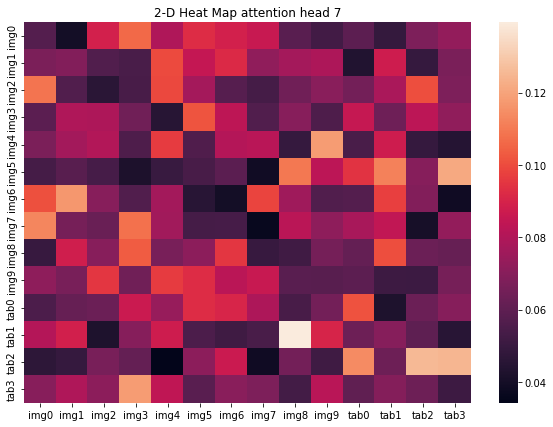

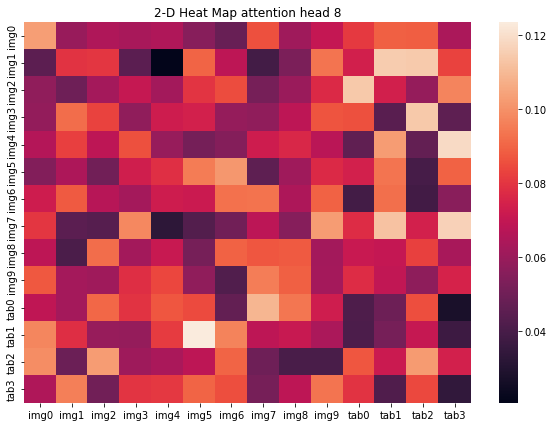

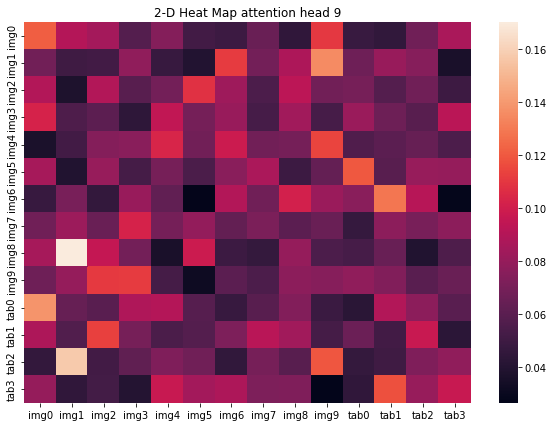

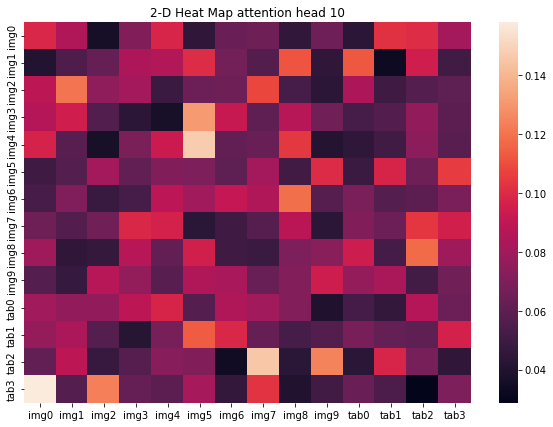

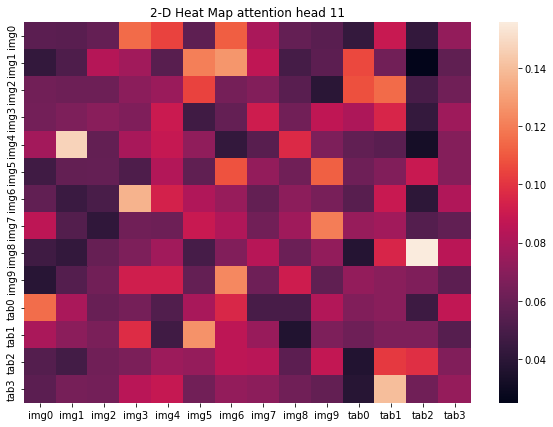

In [18]:
#for a single test input
for k in range(12):
  attention_matrix=transformer_output.attentions[0][0][k].detach().cpu().numpy()
  labels=[f"img{i}" for i in range(img_seq_len)]+[f"tab{j}" for j in range(tabular_seq_len)]
  df_cm=pd.DataFrame(attention_matrix, index=labels,columns=labels)
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=False)
  plt.title( f"2-D Heat Map attention head {k}" )
plt.show()
  